# Calculating the Clustering Ensemble Similarity between ensembles

Here we compare the conformational ensembles of proteins in three trajectories, using the clustering ensemble similarity method.

**Last updated:** January 2020

**Minimum version of MDAnalysis:** 0.21.0

**Packages required:**
    
* MDAnalysis [[1, 2]](#References)
* MDAnalysisTests
* [scikit-learn](https://scikit-learn.org/stable/)
   
**Optional packages for visualisation:**

* [matplotlib](https://matplotlib.org)


<div class="alert alert-info">
    
**Note**

The metrics and methods in the `encore` module are from [(Tiberti *et al.*, 2015)](#References). Please cite them when using the ``MDAnalysis.analysis.encore`` module in published work.

</div>

In [1]:
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import (PSF, DCD, DCD2, GRO, XTC, 
                                        PSF_NAMD_GBIS, DCD_NAMD_GBIS)
from MDAnalysis.analysis import encore
from MDAnalysis.analysis.encore.clustering import ClusteringMethod as clm

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Loading files

The test files we will be working with here feature adenylate kinase (AdK), a phosophotransferase enzyme. [[4]](#References)

In [2]:
u1 = mda.Universe(PSF, DCD)
u2 = mda.Universe(PSF, DCD2)
u3 = mda.Universe(PSF_NAMD_GBIS, DCD_NAMD_GBIS)

labels = ['DCD', 'DCD2', 'NAMD']

The trajectories can have different lengths, as seen below.

In [3]:
print(len(u1.trajectory), len(u2.trajectory), len(u3.trajectory))

98 102 100


## Calculating clustering similarity with default settings

The clustering ensemble similarity method combines every trajectory into a whole space of conformations, and then uses a user-specified `clustering_method` to partition this into clusters. The population of each trajectory ensemble within each cluster is taken as a probability density function.

The similarity of each probability density function is compared using the Jensen-Shannon divergence. This divergence has an upper bound of $\ln{(2)}$, representing no similarity between the ensembles, and a lower bound of 0.0, representing identical conformational ensembles.

You do not need to align your trajectories, as the function will align it for you (along your `selection` atoms, which are `selection='name CA'` by default). 

In [4]:
ces0, details0 = encore.ces([u1, u2, u3])

`encore.ces` returns two outputs. `ces0` is the similarity matrix for the ensemble of trajectories.

In [5]:
ces0

array([[0.        , 0.68070702, 0.69314718],
       [0.68070702, 0.        , 0.69314718],
       [0.69314718, 0.69314718, 0.        ]])

`details0` contains the calculated clusters as a `encore.clustering.ClusterCollection.ClusterCollection`.

In [6]:
cluster_collection = details0['clustering'][0]
print(type(cluster_collection))
print('We have found {} clusters'.format(len(cluster_collection)))

<class 'MDAnalysis.analysis.encore.clustering.ClusterCollection.ClusterCollection'>
We have found 49 clusters


We can access each Cluster at `cluster_collection.clusters`. For example, the first one has these elements:

In [7]:
first_cluster = cluster_collection.clusters[0]
first_cluster

array([ 0,  1,  2,  3, 98])

In [8]:
first_cluster.elements

array([ 0,  1,  2,  3, 98])

Each cluster has an ID number and a centroid conformation.

In [9]:
print('The ID of this cluster is:', first_cluster.id)
print('The centroid is', first_cluster.centroid)

The ID of this cluster is: 0
The centroid is 1


### Plotting

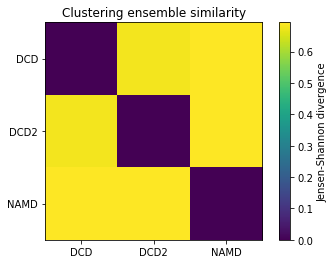

In [11]:
fig0, ax0 = plt.subplots()
im0 = plt.imshow(ces0, vmax=np.log(2), vmin=0)
plt.xticks(np.arange(3), labels)
plt.yticks(np.arange(3), labels)
plt.title('Clustering ensemble similarity')
cbar0 = fig0.colorbar(im0)
cbar0.set_label('Jensen-Shannon divergence')

## Calculating clustering similarity with one method

Clustering methods should be subclasses of `analysis.encore.clustering.ClusteringMethod`, initialised with your chosen parameters. Below, we set up an affinity progragation scheme, which uses message-passing to choose a number of 'exemplar' points to represent the data and updates these points until they converge. The `preference` parameter controls how many exemplars are used -- a higher value results in more clusters, while a lower value results in fewer clusters. The `damping` factor damps the message passing to avoid numerical oscillations. [(See the scikit-learn user guide for more information.)](https://scikit-learn.org/stable/modules/clustering.html#affinity-propagation)

The other keyword arguments control when to stop clustering. Adding noise to the data can also avoid numerical oscillations.

In [12]:
clustering_method = clm.AffinityPropagationNative(preference=-1.0,
                                                  damping=0.9,
                                                  max_iter=200,
                                                  convergence_iter=30,
                                                  add_noise=True)

By default, MDAnalysis will run the job on one core. If it is taking too long and you have the resources, you can increase the number of cores used.

In [13]:
ces1, details1 = encore.ces([u1, u2, u3],
                         selection='name CA',
                         clustering_method=clustering_method,
                         ncores=4)

### Plotting

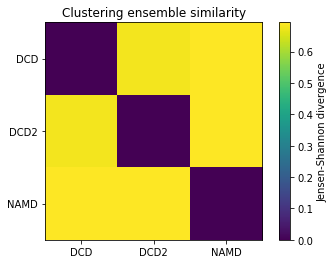

In [14]:
fig1, ax1 = plt.subplots()
im1 = plt.imshow(ces1, vmax=np.log(2), vmin=0)
plt.xticks(np.arange(3), labels)
plt.yticks(np.arange(3), labels)
plt.title('Clustering ensemble similarity')
cbar1 = fig1.colorbar(im1)
cbar1.set_label('Jensen-Shannon divergence')

## Calculating clustering similarity with multiple methods

You may want to try different clustering methods, or use different parameters within the methods. `encore.ces` allows you to pass a list of `clustering_method`s to be applied.

<div class="alert alert-info">
    
**Note**

To use the other ENCORE methods available, you need to install [scikit-learn](https://scikit-learn.org/stable/).

</div>

### Trying out different clustering parameters

The KMeans clustering algorithm separates samples into $n$ groups of equal variance, with centroids that minimise the inertia. You must choose how many clusters to partition. [(See the scikit-learn user guide for more information.)](https://scikit-learn.org/stable/modules/clustering.html#k-means)

In [15]:
km1 = clm.KMeans(12,  # no. clusters
                 init = 'k-means++',  # default
                 algorithm="auto")    # default

km2 = clm.KMeans(6,  # no. clusters
                 init = 'k-means++',  # default
                 algorithm="auto")    # default

The DBSCAN algorithm is a density-based clustering method that defines clusters as 'high density' areas, separated by low density areas. The parameters `min_samples` and `eps` define how dense an area should be to form a cluster. Clusters are defined around core points which have at least `min_samples` neighbours within a distance of `eps`. Points that are at least `eps` in distance from any core point are considered outliers.
[(See the scikit-learn user guide for more information.)](https://scikit-learn.org/stable/modules/clustering.html#dbscan)

A higher `min_samples` or lower `eps` mean that data points must be more dense to form a cluster. You should consider your `eps` carefully. In MDAnalysis, `eps` can be interpreted as the distance between two points in Angstrom.

In [16]:
db1 = clm.DBSCAN(eps=0.5,
                 min_samples=5,
                 algorithm='auto',
                 leaf_size=30)

db2 = clm.DBSCAN(eps=1,
                 min_samples=5,
                 algorithm='auto',
                 leaf_size=30)

When we pass a list of clustering methods to `encore.ces`, the results get saved in `ces2` and `details2` in order.

In [17]:
ces2, details2 = encore.ces([u1, u2, u3],
                         selection='name CA',
                         clustering_method=[km1, km2, db1, db2],
                         ncores=4)
print(len(ces2), len(details2['clustering']))

4 4


### Plotting

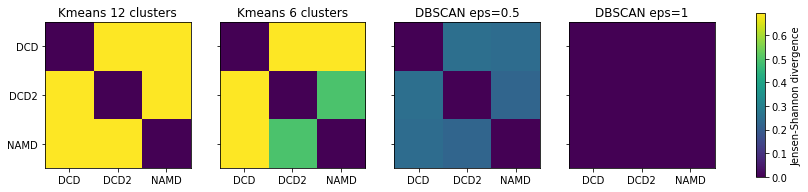

In [18]:
titles = ['Kmeans 12 clusters', 'Kmeans 6 clusters', 'DBSCAN eps=0.5', 'DBSCAN eps=1']
fig2, axes = plt.subplots(1, 4, sharey=True, figsize=(15, 3))
for i, (data, title) in enumerate(zip(ces2, titles)):
    imi = axes[i].imshow(data, vmax=np.log(2), vmin=0)
    axes[i].set_xticks(np.arange(3))
    axes[i].set_xticklabels(labels)
    axes[i].set_title(title)
plt.yticks(np.arange(3), labels)
cbar2 = fig2.colorbar(imi, ax=axes.ravel().tolist())
cbar2.set_label('Jensen-Shannon divergence')

As can be seen, reducing the number of clusters in the K-means method emphasises that DCD2 is more similar to the NAMD trajectory than DCD. Meanwhile, increasing `eps` in DBSCAN clearly lowered the density required to form a cluster so much that every trajectory is in the same cluster, and therefore they have identical probability distributions.

In [19]:
n_db = len(details2['clustering'][-1])

print('Number of clusters in DBSCAN eps=1: {}'.format(n_db))

Number of clusters in DBSCAN eps=1: 1


## Estimating the error in a clustering ensemble similarity analysis

`encore.ces` also allows for error estimation using a bootstrapping method. This returns the average Jensen-Shannon divergence, and standard deviation over the samples. 

In [20]:
avgs, stds = encore.ces([u1, u2, u3],
                         selection='name CA',
                         clustering_method=clustering_method,
                         estimate_error=True,
                         ncores=4)

In [21]:
avgs

array([[0.        , 0.69314718, 0.6880778 ],
       [0.69314718, 0.        , 0.69314718],
       [0.6880778 , 0.69314718, 0.        ]])

In [22]:
stds

array([[0.00000000e+00, 7.02166694e-17, 6.20870337e-03],
       [7.02166694e-17, 0.00000000e+00, 8.59975057e-17],
       [6.20870337e-03, 8.59975057e-17, 0.00000000e+00]])

## References

[1] R. J. Gowers, M. Linke, J. Barnoud, T. J. E. Reddy, M. N. Melo, S. L. Seyler, D. L. Dotson, J. Domanski, S. Buchoux, I. M. Kenney, and O. Beckstein. [MDAnalysis: A Python package for the rapid analysis of molecular dynamics simulations](http://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html). In S. Benthall and S. Rostrup, editors, *Proceedings of the 15th Python in Science Conference*, pages 98-105, Austin, TX, 2016. SciPy, doi: [10.25080/majora-629e541a-00e](https://doi.org/10.25080/majora-629e541a-00e).

[2] N. Michaud-Agrawal, E. J. Denning, T. B. Woolf, and O. Beckstein. MDAnalysis: A Toolkit for the Analysis of Molecular Dynamics Simulations. *J. Comput. Chem*. 32 (2011), 2319-2327, [doi:10.1002/jcc.21787](https://dx.doi.org/10.1002/jcc.21787). PMCID:[PMC3144279](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144279/)

[3] ENCORE: Software for Quantitative Ensemble Comparison. Matteo Tiberti, Elena Papaleo, Tone Bengtsen, Wouter Boomsma, Kresten Lindorff-Larsen. *PLoS Comput Biol.* 2015, 11, e1004415.

[4] Beckstein O, Denning EJ, Perilla JR, Woolf TB. Zipping and unzipping of adenylate kinase: atomistic insights into the ensemble of open<-->closed transitions. *J Mol Biol*. 2009;394(1):160–176. [doi:10.1016/j.jmb.2009.09.009](https://dx.doi.org/10.1016%2Fj.jmb.2009.09.009)
